# Momentum


In gradient descent, we mentioned that the gradient of the objective function's independent variable represents the direction of the objective function's fastest descend at the current position of the independent variable. Therefore, gradient descent is also called steepest descent. In each iteration, the gradient descends according to the current position of the independent variable while updating the latter along the current position of the gradient. However, this can lead to problems if the iterative direction of the independent variable relies exclusively on the current position of the independent variable.

## Exercises with Gradient Descent


Now, we will consider an objective function $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$, whose input and output are a two-dimensional vector $\boldsymbol{x} = [x_1, x_2]$ and a scalar, respectively. In contrast to :numref:chapter_gd, here, the coefficient $x_1^2$ is reduced from $1$ to $0.1$. We are going to implement gradient descent based on this objective function, and demonstrate the iterative trajectory of the independent variable using the learning rate $0.4$.



epoch 20, x1 -0.943467, x2 -0.000073


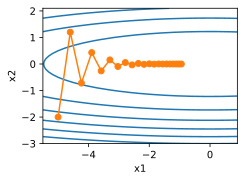

In [1]:
import sys
sys.path.insert(0, '..')
%matplotlib inline
import d2l
import numpy as np
import torch.optim

eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

As we can see, at the same position, the slope of the objective function has a larger absolute value in the vertical direction ($x_2$ axis direction) than in the horizontal direction ($x_1$ axis direction). Therefore, given the learning rate, using gradient descent for interaction will cause the independent variable to move more in the vertical direction than in the horizontal one. So we need a small learning rate to prevent the independent variable from overshooting the optimal solution for the objective function in the vertical direction. However, it will cause the independent variable to move slower toward the optimal solution in the horizontal direction.

Now, we try to make the learning rate slightly larger, so the independent variable will continuously overshoot the optimal solution in the vertical direction and gradually diverge.

epoch 20, x1 -0.387814, x2 -1673.365109


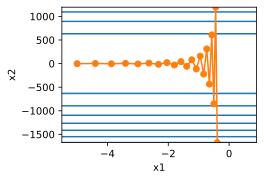

In [2]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

## The Momentum Method


The momentum method was proposed to solve the gradient descent problem described above. Since mini-batch stochastic gradient descent is more general than gradient descent, the subsequent discussion in this chapter will continue to use the definition for mini-batch stochastic gradient descent $\mathbf{g}_t$ at time step $t$ given in :numref:chapter_minibatch_sgd. We set the independent variable at time step $t$ to $\mathbf{x}_t$ and the learning rate to $\eta_t$. At time step $0$, momentum creates the velocity variable $\mathbf{v}_0$ and initializes its elements to zero. At time step $t>0$, momentum modifies the steps of each iteration as follows:

$$ \begin{aligned} \mathbf{v}t &\leftarrow \gamma \mathbf{v}{t-1} + \eta_t \mathbf{g}_t, \ \mathbf{x}t &\leftarrow \mathbf{x}{t-1} - \mathbf{v}_t, \end{aligned} $$

Here, the momentum hyperparameter $\gamma$ satisfies $0 \leq \gamma < 1$. When $\gamma=0$, momentum is equivalent to a mini-batch SGD.

Before explaining the mathematical principles behind the momentum method, we should take a look at the iterative trajectory of the gradient descent after using momentum in the experiment.



epoch 20, x1 -0.062843, x2 0.001202


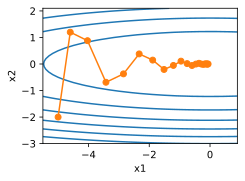

In [3]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, gamma = 0.4, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

As we can see, when using a smaller learning rate ($\eta=0.4$) and momentum hyperparameter ($\gamma=0.5$), momentum moves more smoothly in the vertical direction and approaches the optimal solution faster in the horizontal direction. Now, when we use a larger learning rate ($\eta=0.6$), the independent variable will no longer diverge.

epoch 20, x1 0.007188, x2 0.002553


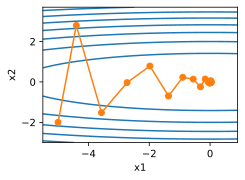

In [4]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### Expanding the velocity variable $\mathbf v_t$

To understand the momentum method, we can expand the velocity variable over time:

$$ \begin{aligned} \mathbf{v}t &= \eta_t \mathbf{g}t + \gamma \mathbf{v}{t-1}, \ &= \eta_t \mathbf{g}t + \gamma \eta{t-1} \mathbf{g}{t-1} + \gamma\mathbf{v}{t-1}, \ &\ldots\ &= \eta_t \mathbf{g}t + \gamma \eta{t-1} \mathbf{g}{t-1} + \ldots + \gamma^{t-1}\eta_1\mathbf g_1. \ \end{aligned} $$

As we can see that $\mathbf v_t$ is a weighted sum over all past gradients multiplied by the according learning rate, which is the weight update in normal gradient descent. We just call it the scaled gradient. The weights deceases exponentially with the speed controlled by $\gamma$.

The following code block shows the weights for the past 40 time steps under various $\gamma$s.

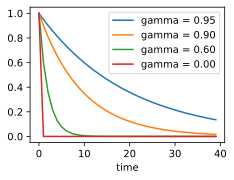

In [5]:
gammas = [0.95, 0.9, 0.6, 0]
d2l.set_figsize((3.5, 2.5))
for gamma in gammas:
    x = np.arange(40)
    d2l.plt.plot(x, gamma ** x, label='gamma = %.2f'%gamma)
d2l.plt.xlabel('time')
d2l.plt.legend();

A small $\gamma$ will let the velocity variable focus on more recent scaled gradients. While a large value will have the velocity variable to include more past scaled gradients. Compared to the plain gradient descent, momentum will make the weight updates be more consistent over time. It might smooth the training progress if $\mathbf x$ enters the region that the gradient vary, or walk out region that is too flat.

Also note that $\frac{1}{1-\gamma} = 1 + \gamma + \gamma^2 + \cdots$. So all scaled gradients are similar to each other, e.g. $\eta_t\mathbf g_t\approx \eta\mathbf g$ for all $t$s, then the momentum changes the weight updates from $\eta\mathbf g$ in normal gradient descent into $\frac{\eta}{1-\gamma} \mathbf g$.



## Implementation from Scratch


Compared with mini-batch SGD, the momentum method needs to maintain a velocity variable of the same shape for each independent variable and a momentum hyperparameter is added to the hyperparameter category. In the implementation, we use the state variable states to represent the velocity variable in a more general sense.



In [6]:
def init_momentum_states(feature_dim):
    v_w = np.zeros((feature_dim, 1))
    v_b = np.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v[:] = hyperparams['momentum'] * v + hyperparams['lr'] * p.grad
        p[:] -= v

## Concise Implementation

In Gluon, we only need to use momentum to define the momentum hyperparameter in the Trainer instance to implement momentum

When we set the momentum hyperparameter momentum to 0.5, it can be treated as a mini-batch SGD: the mini-batch gradient here is the weighted average of twice the mini-batch gradient of the last two time steps.



loss: 0.244, 0.005 sec/epoch


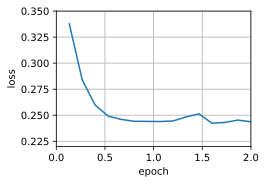

In [7]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch10(torch.optim.SGD, {'lr': lr, 'momentum': momentum}, data_iter, 
                   feature_dim, num_epochs)
    
data_iter, feature_dim = d2l.get_data_ch10(batch_size=10)
train_momentum(0.02, 0.5)

When we increase the momentum hyperparameter momentum to 0.9, it can still be treated as a mini-batch SGD: the mini-batch gradient here will be the weighted average of ten times the mini-batch gradient of the last 10 time steps. Now we keep the learning rate at 0.02.

loss: 0.250, 0.005 sec/epoch


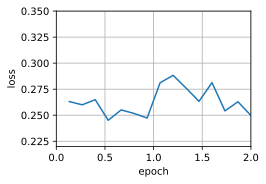

In [8]:
train_momentum(0.02, 0.9)

We can see that the value change of the objective function is not smooth enough at later stages of iteration. Intuitively, ten times the mini-batch gradient is five times larger than two times the mini-batch gradient, so we can try to reduce the learning rate to 1/5 of its original value. Now, the value change of the objective function becomes smoother after its period of decline.

loss: 0.245, 0.005 sec/epoch


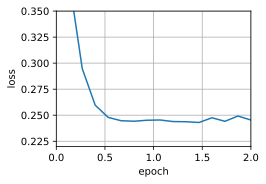

In [9]:
train_momentum(0.004, 0.9)

## Summary
- The momentum method uses the EWMA concept. It takes the weighted average of past time steps, with weights that decay exponentially by the time step.
- Momentum makes independent variable updates for adjacent time steps more consistent in direction.

## Exercises

- Use other combinations of momentum hyperparameters and learning rates and observe and analyze the different experimental results.
